# Reproducing Raschka's BCE vs BCEWithLogitsLoss Experiment

This notebook reproduces Sebastian Raschka's experiment comparing BCELoss vs BCEWithLogitsLoss
using vanilla PyTorch (no Lightning).

**Original findings:**
- BCEWithLogitsLoss: 92.18% accuracy
- BCELoss (with Sigmoid): 50.03% accuracy (random guessing - failed to converge)

**Setup:**
- Model: VGG16 (65M parameters)
- Dataset: CelebA (smile classification)
- Optimizer: Adam (lr=0.001, no weight decay)
- Batch size: 256
- Epochs: 4

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
elif torch.backends.mps.is_available():
    print("MPS (Apple Silicon) available")

PyTorch version: 2.9.1
CUDA available: False
MPS (Apple Silicon) available


## Hyperparameters (matching Raschka's setup)

In [2]:
# Matching Raschka's exact setup
BATCH_SIZE = 256
NUM_EPOCHS = 4
LEARNING_RATE = 0.001

# Note: num_workers=0 required in notebooks on macOS due to multiprocessing pickle issues
# with functions defined in __main__ (like get_smile)
NUM_WORKERS = 0

# Device selection
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")
    
print(f"Using device: {DEVICE}")

Using device: mps


## VGG16 Model (same architecture as Raschka)

In [3]:
class VGG16(nn.Module):
    """VGG16 for binary classification (matching Raschka's implementation)"""
    
    def __init__(self, num_outputs=1):
        super().__init__()
        
        # Block 1
        self.block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 2
        self.block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 3
        self.block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 4
        self.block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Block 5
        self.block_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.features = nn.Sequential(
            self.block_1, self.block_2, self.block_3, 
            self.block_4, self.block_5
        )
        
        # Classifier (for 128x128 input -> 4x4 after all pooling)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_outputs),
        )
        
        # Initialize weights (matching Raschka's initialization)
        self._initialize_weights()
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.05)
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.05)
                m.bias.data.zero_()
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Test the model
model = VGG16(num_outputs=1)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,} ({total_params/1e6:.1f}M)")

Total parameters: 65,058,625 (65.1M)


## CelebA Dataset Setup

In [4]:
# Transforms matching Raschka's setup
custom_transforms = transforms.Compose([
    transforms.CenterCrop((160, 160)),
    transforms.Resize([128, 128]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Target transform to extract smile attribute (index 31)
def get_smile(attr):
    return attr[31]

# Load datasets
# Note: CelebA needs to be downloaded first. If not available, this will attempt to download.
# You may need to download manually from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

DATA_ROOT = './celeba'  # Change this path as needed

try:
    train_dataset = datasets.CelebA(
        root=DATA_ROOT,
        split='train',
        transform=custom_transforms,
        target_type='attr',
        target_transform=get_smile,
        download=True
    )

    test_dataset = datasets.CelebA(
        root=DATA_ROOT,
        split='test',
        transform=custom_transforms,
        target_type='attr',
        target_transform=get_smile,
        download=True
    )
    
    print(f"Training samples: {len(train_dataset):,}")
    print(f"Test samples: {len(test_dataset):,}")
    
except Exception as e:
    print(f"Error loading CelebA: {e}")
    print("\nPlease download CelebA dataset manually from:")
    print("https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html")
    print(f"\nAnd place it in: {DATA_ROOT}")

Training samples: 162,770
Test samples: 19,962


In [5]:
# Create data loaders
# Note: pin_memory only helps with CUDA, not MPS
use_pin_memory = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=use_pin_memory
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=use_pin_memory
)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 636
Test batches: 78


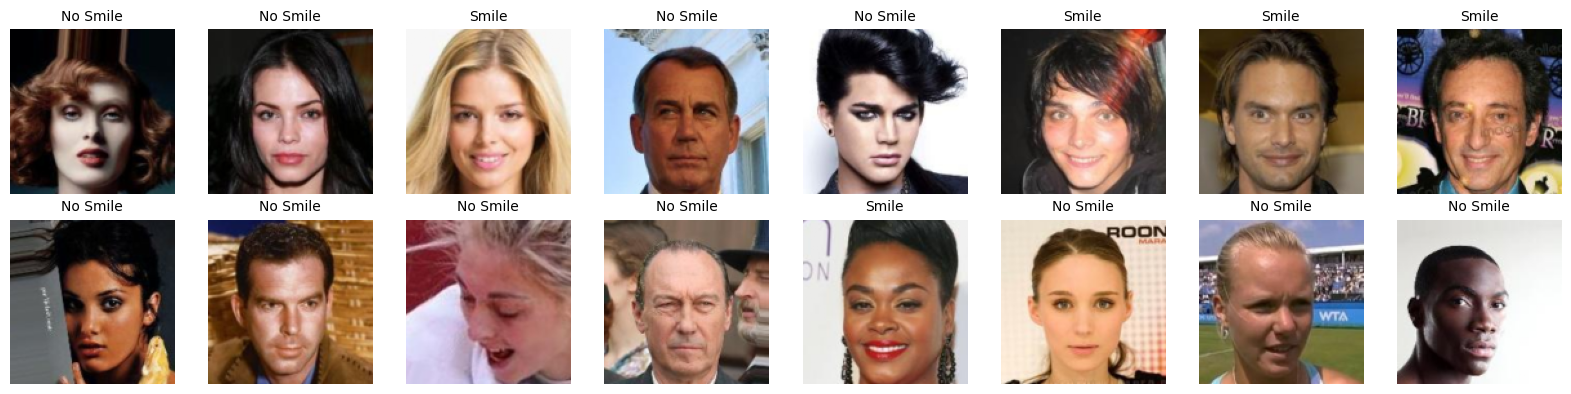

In [6]:
# Visualize some training images
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 8, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0).numpy()
    img = (img * 0.5) + 0.5  # Denormalize
    ax.imshow(img)
    ax.set_title("Smile" if labels[i] == 1 else "No Smile", fontsize=10)
    ax.axis('off')
plt.tight_layout()
plt.show()

## Training Functions

In [7]:
def train_epoch(model, train_loader, loss_fn, optimizer, device, use_logits=True):
    """Train for one epoch and return average loss."""
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images = images.to(device)
        labels = labels.float().to(device)
        
        optimizer.zero_grad()
        outputs = model(images).flatten()
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches


def evaluate(model, test_loader, device, use_logits=True):
    """Evaluate model and return accuracy."""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating", leave=False):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images).flatten()
            
            if use_logits:
                predictions = (outputs > 0.0).long()
            else:
                predictions = (outputs > 0.5).long()
            
            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    
    return correct / total


def train_model(model, train_loader, test_loader, loss_fn, optimizer, 
                device, num_epochs, use_logits=True, name="Model"):
    """Full training loop."""
    print(f"\n{'='*60}")
    print(f"Training: {name}")
    print(f"{'='*60}")
    
    history = {'train_loss': [], 'test_acc': []}
    
    start_time = time.time()
    
    for epoch in range(num_epochs):
        epoch_start = time.time()
        
        # Train
        train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, use_logits)
        
        # Evaluate
        test_acc = evaluate(model, test_loader, device, use_logits)
        
        epoch_time = time.time() - epoch_start
        
        history['train_loss'].append(train_loss)
        history['test_acc'].append(test_acc)
        
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Loss: {train_loss:.4f} | "
              f"Test Acc: {test_acc:.4f} ({test_acc*100:.2f}%) | "
              f"Time: {epoch_time:.1f}s")
    
    total_time = time.time() - start_time
    print(f"\nTotal training time: {total_time/60:.2f} minutes")
    print(f"Final test accuracy: {history['test_acc'][-1]*100:.2f}%")
    
    return history

## Experiment 1: BCEWithLogitsLoss (Expected: ~92% accuracy)

In [8]:
# Create model for BCEWithLogitsLoss
model_logits = VGG16(num_outputs=1).to(DEVICE)

# Loss function: BCEWithLogitsLoss (numerically stable)
loss_fn_logits = nn.BCEWithLogitsLoss()

# Optimizer: Adam with no weight decay (matching Raschka)
optimizer_logits = optim.Adam(model_logits.parameters(), lr=LEARNING_RATE)

print("Model: VGG16 with BCEWithLogitsLoss")
print(f"Parameters: {sum(p.numel() for p in model_logits.parameters()):,}")

Model: VGG16 with BCEWithLogitsLoss
Parameters: 65,058,625


In [9]:
# Train with BCEWithLogitsLoss
history_logits = train_model(
    model_logits, train_loader, test_loader,
    loss_fn_logits, optimizer_logits, DEVICE,
    num_epochs=NUM_EPOCHS,
    use_logits=True,
    name="BCEWithLogitsLoss"
)


Training: BCEWithLogitsLoss


Epoch 1/4 | Loss: 122.5881 | Test Acc: 0.8994 (89.94%) | Time: 1177.7s


Epoch 2/4 | Loss: 0.2232 | Test Acc: 0.9133 (91.33%) | Time: 1154.1s


Epoch 3/4 | Loss: 0.2062 | Test Acc: 0.9134 (91.34%) | Time: 1145.8s


Epoch 4/4 | Loss: 0.1976 | Test Acc: 0.9148 (91.48%) | Time: 1141.3s

Total training time: 76.98 minutes
Final test accuracy: 91.48%


## Experiment 2: BCELoss with Sigmoid (Expected: ~50% accuracy - fails to converge)

In [10]:
# Create model for BCELoss (with Sigmoid at the end)
model_bce = VGG16(num_outputs=1).to(DEVICE)

# Add Sigmoid to the end of the classifier (matching Raschka's setup)
model_bce.classifier.add_module('sigmoid', nn.Sigmoid())

# Loss function: BCELoss (expects probabilities in [0, 1])
loss_fn_bce = nn.BCELoss()

# Optimizer: Adam with no weight decay (matching Raschka)
optimizer_bce = optim.Adam(model_bce.parameters(), lr=LEARNING_RATE)

print("Model: VGG16 with Sigmoid + BCELoss")
print(f"Parameters: {sum(p.numel() for p in model_bce.parameters()):,}")

Model: VGG16 with Sigmoid + BCELoss
Parameters: 65,058,625


In [11]:
# Train with BCELoss
history_bce = train_model(
    model_bce, train_loader, test_loader,
    loss_fn_bce, optimizer_bce, DEVICE,
    num_epochs=NUM_EPOCHS,
    use_logits=False,  # Output is probability, threshold at 0.5
    name="Sigmoid + BCELoss"
)


Training: Sigmoid + BCELoss


Epoch 1/4 | Loss: 52.0358 | Test Acc: 0.5003 (50.03%) | Time: 1159.0s


Epoch 2/4 | Loss: 52.0318 | Test Acc: 0.5003 (50.03%) | Time: 1175.7s


Epoch 3/4 | Loss: 52.0319 | Test Acc: 0.5003 (50.03%) | Time: 1187.8s


Epoch 4/4 | Loss: 52.0310 | Test Acc: 0.5003 (50.03%) | Time: 1182.7s

Total training time: 78.42 minutes
Final test accuracy: 50.03%


## Results Comparison

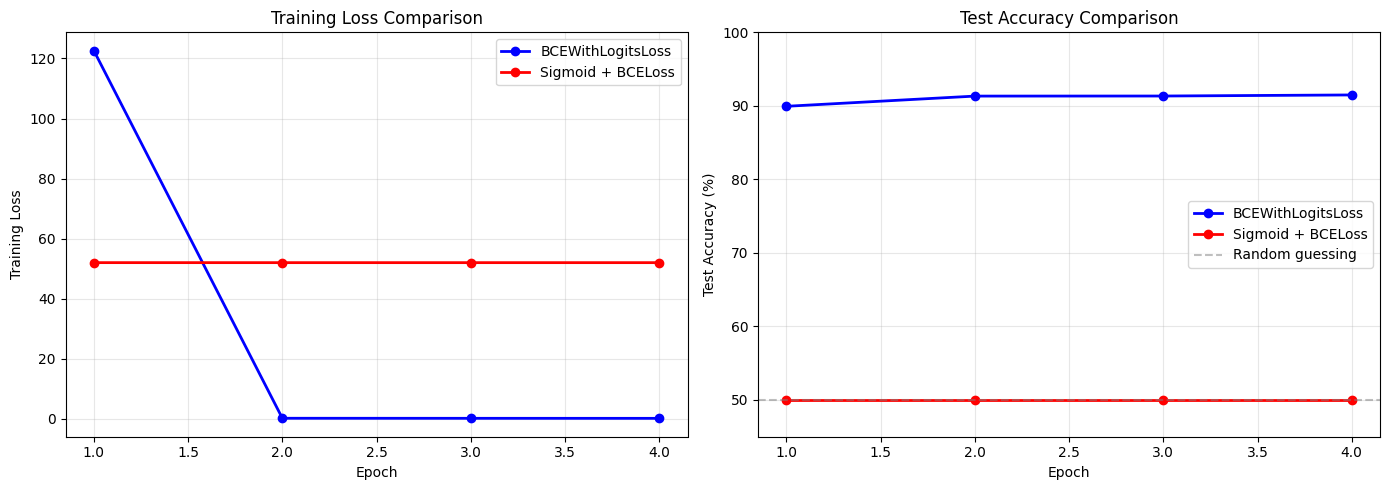

In [12]:
# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, NUM_EPOCHS + 1)

# Training Loss
axes[0].plot(epochs, history_logits['train_loss'], 'b-o', label='BCEWithLogitsLoss', linewidth=2)
axes[0].plot(epochs, history_bce['train_loss'], 'r-o', label='Sigmoid + BCELoss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Training Loss')
axes[0].set_title('Training Loss Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Test Accuracy
axes[1].plot(epochs, [a*100 for a in history_logits['test_acc']], 'b-o', label='BCEWithLogitsLoss', linewidth=2)
axes[1].plot(epochs, [a*100 for a in history_bce['test_acc']], 'r-o', label='Sigmoid + BCELoss', linewidth=2)
axes[1].axhline(y=50, color='gray', linestyle='--', alpha=0.5, label='Random guessing')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Test Accuracy (%)')
axes[1].set_title('Test Accuracy Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([45, 100])

plt.tight_layout()
plt.savefig('raschka_reproduction_results.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Summary table
print("\n" + "="*70)
print("RESULTS SUMMARY")
print("="*70)
print(f"{'Method':<30} {'Final Accuracy':>15} {'Raschka\'s Result':>20}")
print("-"*70)
print(f"{'BCEWithLogitsLoss':<30} {history_logits['test_acc'][-1]*100:>14.2f}% {92.18:>19.2f}%")
print(f"{'Sigmoid + BCELoss':<30} {history_bce['test_acc'][-1]*100:>14.2f}% {50.03:>19.2f}%")
print("-"*70)
print(f"{'Difference':<30} {(history_logits['test_acc'][-1] - history_bce['test_acc'][-1])*100:>14.2f}pp {42.15:>19.2f}pp")
print("="*70)


RESULTS SUMMARY
Method                          Final Accuracy     Raschka's Result
----------------------------------------------------------------------
BCEWithLogitsLoss                       91.48%               92.18%
Sigmoid + BCELoss                       50.03%               50.03%
----------------------------------------------------------------------
Difference                              41.45pp               42.15pp


## Analysis: Why Does BCELoss Fail?

Let's examine the gradient behavior to understand the failure mode.

In [14]:
# Analyze what happens with extreme logits
import torch.nn.functional as F

# Simulate extreme logit values
logits = torch.tensor([-100., -50., -10., 0., 10., 50., 100.], requires_grad=True)
target = torch.tensor([1., 1., 1., 1., 1., 1., 1.])  # All positive examples

# BCEWithLogitsLoss gradients
loss_with_logits = F.binary_cross_entropy_with_logits(logits, target)
loss_with_logits.backward()
grads_with_logits = logits.grad.clone()
logits.grad.zero_()

# Sigmoid + BCELoss gradients
logits2 = torch.tensor([-100., -50., -10., 0., 10., 50., 100.], requires_grad=True)
probs = torch.sigmoid(logits2)
# Clamp to avoid log(0)
probs_clamped = probs.clamp(min=1e-7, max=1-1e-7)
loss_bce = F.binary_cross_entropy(probs_clamped, target)
loss_bce.backward()
grads_bce = logits2.grad.clone()

print("Gradient Analysis for Positive Examples (target=1)")
print("="*70)
print(f"{'Logit':>10} {'Sigmoid':>12} {'Grad (WithLogits)':>18} {'Grad (BCE)':>15}")
print("-"*70)
for i, l in enumerate(logits.detach()):
    print(f"{l.item():>10.1f} {torch.sigmoid(l).item():>12.6f} "
          f"{grads_with_logits[i].item():>18.6f} {grads_bce[i].item():>15.6f}")
print("="*70)
print("\nNote: For very negative logits (wrong predictions with high confidence),")
print("BCEWithLogitsLoss maintains gradients while Sigmoid+BCE has vanishing gradients.")

Gradient Analysis for Positive Examples (target=1)
     Logit      Sigmoid  Grad (WithLogits)      Grad (BCE)
----------------------------------------------------------------------
    -100.0     0.000000          -0.142857        0.000000
     -50.0     0.000000          -0.142857        0.000000
     -10.0     0.000045          -0.142851       -0.142851
       0.0     0.500000          -0.071429       -0.071429
      10.0     0.999955          -0.000006       -0.000006
      50.0     1.000000           0.000000        0.000000
     100.0     1.000000           0.000000        0.000000

Note: For very negative logits (wrong predictions with high confidence),
BCEWithLogitsLoss maintains gradients while Sigmoid+BCE has vanishing gradients.


LOGIT ANALYSIS (on one test batch)

Statistic               BCEWithLogitsLoss     BCELoss (pre-sigmoid)
----------------------------------------------------------------------
Min                                 -6.78             3265233408.00
Max                                 10.00             6722117632.00
Mean                                 1.19             5019848704.00
Std                                  4.36              702758144.00
|logit| > 10                            0                       256
|logit| > 50                            0                       256
|logit| > 100                           0                       256


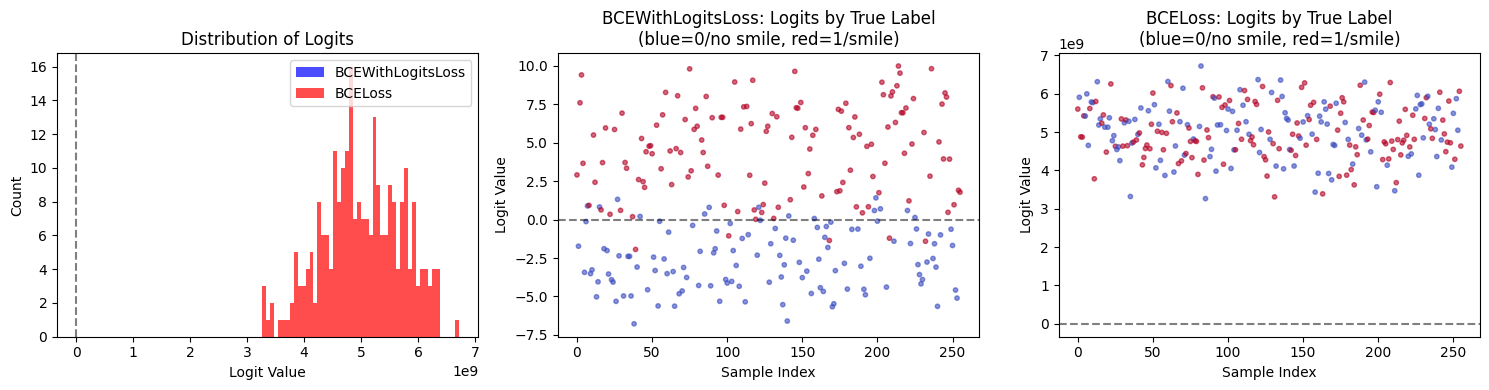


BCELoss model predictions:
  Predicting class 0 (no smile): 0 / 256
  Predicting class 1 (smile): 256 / 256

Actual labels in batch:
  Class 0: 121


In [15]:
# Get a batch of test data
images, labels = next(iter(test_loader))
images = images.to(DEVICE)
labels = labels.to(DEVICE)

# Model 1: BCEWithLogitsLoss model - outputs raw logits directly
model_logits.eval()
with torch.no_grad():
    logits_from_logits_model = model_logits(images).flatten()

# Model 2: BCELoss model - need to get logits BEFORE sigmoid
# Remove sigmoid temporarily to get raw logits
model_bce.eval()
sigmoid_layer = model_bce.classifier[-1]  # Save the sigmoid
model_bce.classifier = model_bce.classifier[:-1]  # Remove sigmoid

with torch.no_grad():
    logits_from_bce_model = model_bce(images).flatten()

# Restore sigmoid
model_bce.classifier.add_module('sigmoid', sigmoid_layer)

# Move to CPU for analysis
logits_logits = logits_from_logits_model.cpu().numpy()
logits_bce = logits_from_bce_model.cpu().numpy()
labels_np = labels.cpu().numpy()

# Print statistics
print("=" * 70)
print("LOGIT ANALYSIS (on one test batch)")
print("=" * 70)
print(f"\n{'Statistic':<20} {'BCEWithLogitsLoss':>20} {'BCELoss (pre-sigmoid)':>25}")
print("-" * 70)
print(f"{'Min':<20} {logits_logits.min():>20.2f} {logits_bce.min():>25.2f}")
print(f"{'Max':<20} {logits_logits.max():>20.2f} {logits_bce.max():>25.2f}")
print(f"{'Mean':<20} {logits_logits.mean():>20.2f} {logits_bce.mean():>25.2f}")
print(f"{'Std':<20} {logits_logits.std():>20.2f} {logits_bce.std():>25.2f}")
print(f"{'|logit| > 10':<20} {(np.abs(logits_logits) > 10).sum():>20} {(np.abs(logits_bce) > 10).sum():>25}")
print(f"{'|logit| > 50':<20} {(np.abs(logits_logits) > 50).sum():>20} {(np.abs(logits_bce) > 50).sum():>25}")
print(f"{'|logit| > 100':<20} {(np.abs(logits_logits) > 100).sum():>20} {(np.abs(logits_bce) > 100).sum():>25}")
print("=" * 70)

# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram of logits
axes[0].hist(logits_logits, bins=50, alpha=0.7, label='BCEWithLogitsLoss', color='blue')
axes[0].hist(logits_bce, bins=50, alpha=0.7, label='BCELoss', color='red')
axes[0].set_xlabel('Logit Value')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Logits')
axes[0].legend()
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.5)

# Logits vs labels (BCEWithLogitsLoss)
axes[1].scatter(range(len(logits_logits)), logits_logits, c=labels_np, cmap='coolwarm', alpha=0.6, s=10)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Logit Value')
axes[1].set_title('BCEWithLogitsLoss: Logits by True Label\n(blue=0/no smile, red=1/smile)')

# Logits vs labels (BCELoss)
axes[2].scatter(range(len(logits_bce)), logits_bce, c=labels_np, cmap='coolwarm', alpha=0.6, s=10)
axes[2].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Sample Index')
axes[2].set_ylabel('Logit Value')
axes[2].set_title('BCELoss: Logits by True Label\n(blue=0/no smile, red=1/smile)')

plt.tight_layout()
plt.show()

# Check if BCELoss model is just predicting one class
probs_bce = torch.sigmoid(torch.tensor(logits_bce)).numpy()
print(f"\nBCELoss model predictions:")
print(f"  Predicting class 0 (no smile): {(logits_bce < 0).sum()} / {len(logits_bce)}")
print(f"  Predicting class 1 (smile): {(logits_bce >= 0).sum()} / {len(logits_bce)}")
print(f"\nActual labels in batch:")
print(f"  Class 0: {(labels_np == 0).sum()}")

INITIALIZATION COMPARISON (UNTRAINED MODELS - Single Forward Pass)

Statistic          Raschka (N(0,0.05))      PyTorch Default         Kaiming
--------------------------------------------------------------------------------
Min                         -1035.4060               0.0069         -2.9565
Max                           175.9788               0.0069         11.2453
Mean                         -414.6471               0.0069          4.6690
Std                           226.9548               0.0000          2.1942
|logit| > 1                        256                    0             249
|logit| > 10                       256                    0               2


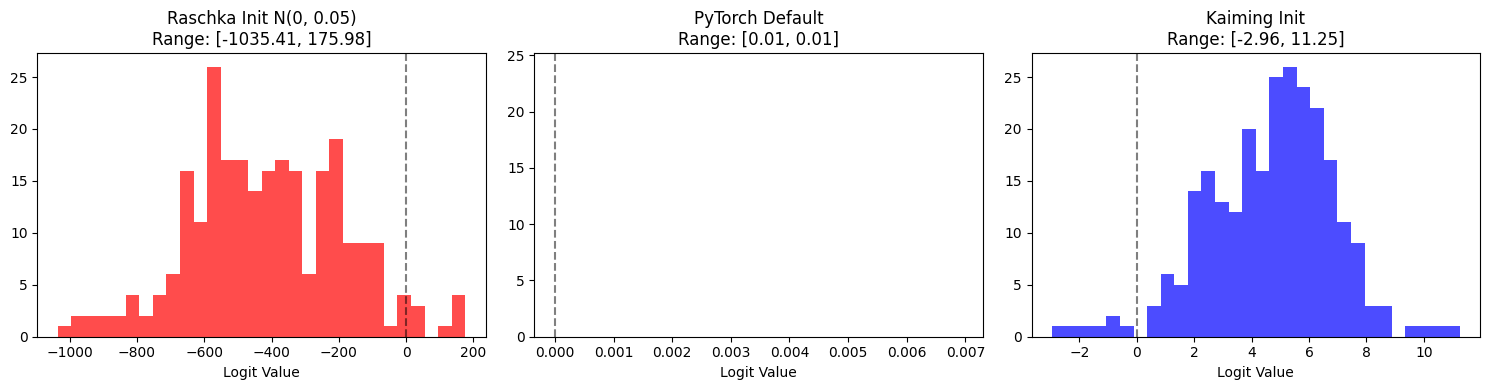


Sigmoid outputs (what BCELoss would see):
  Raschka:  min=0.000000, max=1.000000
  Default:  min=0.501737, max=0.501737
  Kaiming:  min=0.049432, max=0.999987


/var/folders/jc/7dm_cdvn0759gz0xtck_ncvw0000gn/T/ipykernel_50895/3099374330.py:144: RuntimeWarning: overflow encountered in exp
  print(f"  Raschka:  min={1/(1+np.exp(-logits_raschka.min())):.6f}, max={1/(1+np.exp(-logits_raschka.max())):.6f}")


In [16]:
# Test initialization hypothesis
# Create fresh models with different initializations

# Model 1: Raschka's initialization (normal with std=0.05)
model_raschka_init = VGG16(num_outputs=1).to(DEVICE)  # Uses _initialize_weights internally

# Model 2: PyTorch default initialization (no custom init)
class VGG16_DefaultInit(nn.Module):
    """Same VGG16 but WITHOUT custom initialization"""
    def __init__(self, num_outputs=1):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.features = nn.Sequential(
            self.block_1, self.block_2, self.block_3,
            self.block_4, self.block_5
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=0.5),
            nn.Linear(4096, num_outputs),
        )
        # NO custom initialization - uses PyTorch defaults (Kaiming for Conv/Linear)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model_default_init = VGG16_DefaultInit(num_outputs=1).to(DEVICE)

# Model 3: Kaiming initialization (recommended for ReLU networks)
class VGG16_KaimingInit(VGG16_DefaultInit):
    def __init__(self, num_outputs=1):
        super().__init__(num_outputs)
        # Apply Kaiming initialization explicitly
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.zeros_(m.bias)

model_kaiming_init = VGG16_KaimingInit(num_outputs=1).to(DEVICE)

# Get a batch
images, labels = next(iter(test_loader))
images = images.to(DEVICE)

# Forward pass on all three (untrained) models
model_raschka_init.eval()
model_default_init.eval()
model_kaiming_init.eval()

with torch.no_grad():
    logits_raschka = model_raschka_init(images).flatten().cpu().numpy()
    logits_default = model_default_init(images).flatten().cpu().numpy()
    logits_kaiming = model_kaiming_init(images).flatten().cpu().numpy()

# Compare initial logit distributions
print("=" * 80)
print("INITIALIZATION COMPARISON (UNTRAINED MODELS - Single Forward Pass)")
print("=" * 80)
print(f"\n{'Statistic':<15} {'Raschka (N(0,0.05))':>22} {'PyTorch Default':>20} {'Kaiming':>15}")
print("-" * 80)
print(f"{'Min':<15} {logits_raschka.min():>22.4f} {logits_default.min():>20.4f} {logits_kaiming.min():>15.4f}")
print(f"{'Max':<15} {logits_raschka.max():>22.4f} {logits_default.max():>20.4f} {logits_kaiming.max():>15.4f}")
print(f"{'Mean':<15} {logits_raschka.mean():>22.4f} {logits_default.mean():>20.4f} {logits_kaiming.mean():>15.4f}")
print(f"{'Std':<15} {logits_raschka.std():>22.4f} {logits_default.std():>20.4f} {logits_kaiming.std():>15.4f}")
print(f"{'|logit| > 1':<15} {(np.abs(logits_raschka) > 1).sum():>22} {(np.abs(logits_default) > 1).sum():>20} {(np.abs(logits_kaiming) > 1).sum():>15}")
print(f"{'|logit| > 10':<15} {(np.abs(logits_raschka) > 10).sum():>22} {(np.abs(logits_default) > 10).sum():>20} {(np.abs(logits_kaiming) > 10).sum():>15}")
print("=" * 80)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(logits_raschka, bins=30, alpha=0.7, color='red')
axes[0].set_title(f'Raschka Init N(0, 0.05)\nRange: [{logits_raschka.min():.2f}, {logits_raschka.max():.2f}]')
axes[0].set_xlabel('Logit Value')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.5)

axes[1].hist(logits_default, bins=30, alpha=0.7, color='green')
axes[1].set_title(f'PyTorch Default\nRange: [{logits_default.min():.2f}, {logits_default.max():.2f}]')
axes[1].set_xlabel('Logit Value')
axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.5)

axes[2].hist(logits_kaiming, bins=30, alpha=0.7, color='blue')
axes[2].set_title(f'Kaiming Init\nRange: [{logits_kaiming.min():.2f}, {logits_kaiming.max():.2f}]')
axes[2].set_xlabel('Logit Value')
axes[2].axvline(x=0, color='black', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Check sigmoid outputs for each
print("\nSigmoid outputs (what BCELoss would see):")
print(f"  Raschka:  min={1/(1+np.exp(-logits_raschka.min())):.6f}, max={1/(1+np.exp(-logits_raschka.max())):.6f}")
print(f"  Default:  min={1/(1+np.exp(-logits_default.min())):.6f}, max={1/(1+np.exp(-logits_default.max())):.6f}")
print(f"  Kaiming:  min={1/(1+np.exp(-logits_kaiming.min())):.6f}, max={1/(1+np.exp(-logits_kaiming.max())):.6f}")

In [17]:
# Experiment 3: BCELoss with PROPER (Kaiming) initialization
print("=" * 60)
print("Experiment 3: BCELoss + Kaiming Initialization")
print("=" * 60)

# Create model with Kaiming init (no custom init)
model_bce_kaiming = VGG16_DefaultInit(num_outputs=1).to(DEVICE)

# Apply proper Kaiming initialization for ReLU networks
for m in model_bce_kaiming.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        nn.init.zeros_(m.bias)

# Add sigmoid for BCELoss
model_bce_kaiming.classifier.add_module('sigmoid', nn.Sigmoid())

# Verify initial logits are sane
model_bce_kaiming.eval()
with torch.no_grad():
    # Remove sigmoid temporarily
    sigmoid_layer = model_bce_kaiming.classifier[-1]
    model_bce_kaiming.classifier = model_bce_kaiming.classifier[:-1]
    test_logits = model_bce_kaiming(images).flatten().cpu().numpy()
    model_bce_kaiming.classifier.add_module('sigmoid', sigmoid_layer)

print(f"Initial logits - Min: {test_logits.min():.4f}, Max: {test_logits.max():.4f}")
print(f"Initial sigmoid - Min: {1/(1+np.exp(-test_logits.min())):.4f}, Max: {1/(1+np.exp(-test_logits.max())):.4f}")

# Setup optimizer and loss
loss_fn_bce_kaiming = nn.BCELoss()
optimizer_bce_kaiming = optim.Adam(model_bce_kaiming.parameters(), lr=LEARNING_RATE)

print(f"\nModel: VGG16 with Kaiming Init + Sigmoid + BCELoss")
print(f"Parameters: {sum(p.numel() for p in model_bce_kaiming.parameters()):,}")

# Train!
history_bce_kaiming = train_model(
    model_bce_kaiming, train_loader, test_loader,
    loss_fn_bce_kaiming, optimizer_bce_kaiming, DEVICE,
    num_epochs=NUM_EPOCHS,
    use_logits=False,
    name="Kaiming Init + Sigmoid + BCELoss"
)

# Compare all three
print("\n" + "=" * 80)
print("FINAL COMPARISON - ALL THREE EXPERIMENTS")
print("=" * 80)
print(f"{'Method':<45} {'Final Accuracy':>15}")
print("-" * 80)
print(f"{'BCEWithLogitsLoss (Raschka init)':<45} {history_logits['test_acc'][-1]*100:>14.2f}%")
print(f"{'BCELoss + Sigmoid (Raschka init)':<45} {history_bce['test_acc'][-1]*100:>14.2f}%")
print(f"{'BCELoss + Sigmoid (Kaiming init)':<45} {history_bce_kaiming['test_acc'][-1]*100:>14.2f}%")
print("=" * 80)

Experiment 3: BCELoss + Kaiming Initialization
Initial logits - Min: 1.8965, Max: 10.5758
Initial sigmoid - Min: 0.8695, Max: 1.0000

Model: VGG16 with Kaiming Init + Sigmoid + BCELoss
Parameters: 65,058,625

Training: Kaiming Init + Sigmoid + BCELoss


Epoch 1/4 | Loss: 47.9040 | Test Acc: 0.4997 (49.97%) | Time: 1167.7s


Epoch 2/4 | Loss: 47.9677 | Test Acc: 0.4997 (49.97%) | Time: 1151.1s


Epoch 3/4 | Loss: 47.9679 | Test Acc: 0.4997 (49.97%) | Time: 1154.1s


Epoch 4/4 | Loss: 47.9698 | Test Acc: 0.4997 (49.97%) | Time: 1159.2s

Total training time: 77.20 minutes
Final test accuracy: 49.97%

FINAL COMPARISON - ALL THREE EXPERIMENTS
Method                                         Final Accuracy
--------------------------------------------------------------------------------
BCEWithLogitsLoss (Raschka init)                       91.48%
BCELoss + Sigmoid (Raschka init)                       50.03%
BCELoss + Sigmoid (Kaiming init)                       49.97%


In [18]:
# Experiment 4: BCELoss with PyTorch DEFAULT initialization (the one that gave 0.5 outputs)
print("=" * 60)
print("Experiment 4: BCELoss + PyTorch Default Initialization")
print("=" * 60)

model_bce_default = VGG16_DefaultInit(num_outputs=1).to(DEVICE)
# NO additional initialization - just use PyTorch defaults

# Verify initial logits
model_bce_default.eval()
with torch.no_grad():
    test_logits = model_bce_default(images).flatten().cpu().numpy()
print(f"Initial logits - Min: {test_logits.min():.4f}, Max: {test_logits.max():.4f}")
print(f"Initial sigmoid - Min: {1/(1+np.exp(-test_logits.min())):.6f}, Max: {1/(1+np.exp(-test_logits.max())):.6f}")

# Add sigmoid
model_bce_default.classifier.add_module('sigmoid', nn.Sigmoid())

loss_fn_default = nn.BCELoss()
optimizer_default = optim.Adam(model_bce_default.parameters(), lr=LEARNING_RATE)

history_bce_default = train_model(
    model_bce_default, train_loader, test_loader,
    loss_fn_default, optimizer_default, DEVICE,
    num_epochs=NUM_EPOCHS,
    use_logits=False,
    name="PyTorch Default Init + BCELoss"
)

print(f"\nFinal: {history_bce_default['test_acc'][-1]*100:.2f}%")

Experiment 4: BCELoss + PyTorch Default Initialization
Initial logits - Min: -0.0045, Max: -0.0045
Initial sigmoid - Min: 0.498883, Max: 0.498883

Training: PyTorch Default Init + BCELoss


Epoch 1/4 | Loss: 0.6925 | Test Acc: 0.4997 (49.97%) | Time: 1173.6s


Epoch 2/4 | Loss: 0.6924 | Test Acc: 0.4997 (49.97%) | Time: 1183.1s


Epoch 3/4 | Loss: 0.6924 | Test Acc: 0.4997 (49.97%) | Time: 1166.0s


Epoch 4/4 | Loss: 0.6923 | Test Acc: 0.4997 (49.97%) | Time: 1159.1s

Total training time: 78.03 minutes
Final test accuracy: 49.97%

Final: 49.97%
